In [1]:
import numpy as np
import os
import pandas as pd
from scipy.optimize import minimize, fixed_point
from scipy.stats import norm
import random
import tqdm
from random import choices
import itertools
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [3]:
# load data
paths = ['nfxp/dat/g870.asc', # 36 x 15 -- Grumman 1983 
         'nfxp/dat/rt50.asc', # 60 x 4 -- Chance 1981
         'nfxp/dat/t8h203.asc', # 81 x 48 -- GMC 1979
         'nfxp/dat/a530875.asc', # 128 x 37 -- GMC 1975 
         'nfxp/dat/a530874.asc', # 137 x 12 -- GMC 1974 (8V)
         'nfxp/dat/a452374.asc', # 137 x 10 -- GMC 1974 (6V)
         'nfxp/dat/a530872.asc', # 137 x 18 -- GMC 1972 (8V)
         'nfxp/dat/a452372.asc' #  137 x 18 -- GMC 1972 (6V)
        ]

shapes = [(36, 15), (60,4), (81, 48), (128, 37),
          (137, 12), (137, 10), (137, 18), (137, 18)]
def read_asc(path, shape):
    f = np.array(pd.read_table(path, header = None).iloc[:, 0])
    return f.reshape(shape, order = 'F')

files = []
for i in range(len(paths)):
    files.append(read_asc(paths[i], shapes[i]))

In [4]:
def discretize(x):
    return np.floor(x/5000)

In [5]:
def prepare(files):
    frames = []
    for file in files:
        group = []
        for i in range(file.shape[1]):
            bus = file[:, i]
            rep1, rep2 = bus[5], bus[8]
            x = bus[11:]
            i = np.zeros_like(x)
            if len(x[(x >= rep1)*(rep1 > 0)])> 0:
                change1 = min(x[(x >= rep1)*(rep1 > 0)])
                i[x == change1] = 1
            if len(x[(x >= rep2)*(rep2 > 0)]) > 0:
                change2 = min(x[(x >= rep2)*(rep2 > 0)])
                i[x == change2] = 1
            x = discretize(x)
            dx = [x[i]-x[i-1] for i in range(1, len(x))]
            dx.insert(0, x[0])
            df = pd.DataFrame({'x': x, 'dx': dx, 'i': i})
            group.append(df)
        group = pd.concat(group, axis = 0, ignore_index = True)
        frames.append(group)
    return frames

files = prepare(files)

In [6]:
data = pd.concat(files[:4], axis = 0, ignore_index = True)

## Static Model

In [7]:
class Static:
    def __init__(self, 
                 data, cost_type = 'linear',
                 scale = 0.001, theta1_init = [0.9], RC_init = 9,
                 disp = False, B = 100, boot = True, 
                 alpha = 0.05):
        
        self.x, self.i = data.x, data.i
        self.cost_type = cost_type
        self.scale = scale
        self.theta1_init = theta1_init
        self.RC_init = RC_init
        self.disp = disp
        self.boot = boot
        self.B = B
        self.alpha = alpha
        
        self.result = self.est_theta(x = self.x, i = self.i)
        
        if boot: self.result_boot = self.bootstrap()
        
    def bootstrap(self): # perform bootstrap
        print('Performing Bootstrap')
        x, i = np.array(self.x), np.array(self.i)
        ind = range(len(x)) # indices
        result_boot = []
        for b in tqdm.trange(self.B):
            ind_b = choices(ind, k = len(x)) # choose with replacement
            x_b, i_b = x[ind_b], i[ind_b] # take values
            result_b = self.est_theta(x = x_b, i = i_b)
            result_boot.append(result_b)
        print('Bootstrap Completed')
        return result_boot

    def output(self):
        cost_type = self.cost_type
        if cost_type == 'linear':
            names = ['theta10', 'RC']
        if cost_type == 'quadratic':
            names = ['theta10', 'theta11', 'RC']
        estimates = self.result
        output = pd.DataFrame({'params': names, 'est': estimates})
        if self.boot:
            param = self.result
            param_b = self.result_boot
            boot_se = []
            for k in range(len(param)):
                diff = []
                for est_b in param_b:
                    diff.append(np.abs(param[k] - est_b[k]))
                boot_se.append(np.quantile(diff, 1 - self.alpha)/norm.ppf(1 - self.alpha/2))
            output['boot_se'] = boot_se
        return output
        
        
    def cost(self, theta1):
        cost_type = self.cost_type
        scale = self.scale
        x = np.arange(90)
        theta1 = np.array(theta1)
        if cost_type == 'linear': return scale* theta1*x
        if cost_type == 'quadratic': return scale*(theta1[0]*x + theta1[1]*(x**2))
        
    def Pi(self, theta1, RC):
        denom = 1 + np.exp(RC - self.cost(theta1))
        P1 = 1/denom
        P0 = 1 - P1
        return P0, P1
        
    def negLL(self, theta, x, i):
        theta1 = theta[:-1]
        RC = theta[-1]
        P0, P1 = self.Pi(theta1, RC)
        LL = 0
        for t in range(len(x)):
            if i[t] == 0: LL += np.log(P0[int(x[t])])
            if i[t] == 1: LL += np.log(P1[int(x[t])])
        return -LL
    
    def cost_constr(self, theta):
        theta1 = theta[:-1]
        RC = theta[-1]
        cost_temp = self.cost(theta1)
        if (cost_temp >= 0).all() and (RC >= 0): return 0
        else                                   : return -1
         
    def est_theta(self, x, i):
        theta_init = []
        theta_init.extend(self.theta1_init)
        theta_init.append(self.RC_init)
        res = minimize(self.negLL, x0 = theta_init, method = 'Nelder-Mead',
                      constraints = {'type': 'eq', 'fun': self.cost_constr},
                      options = {'disp': self.disp},
                      args = (x, i))
        return res.x

In [9]:
s_linear = Static(data, cost_type='linear', 
                  theta1_init=[9], RC_init=200, B=100)

Performing Bootstrap


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]

Bootstrap Completed


In [10]:
print(s_linear.output().to_latex())

\begin{tabular}{llrr}
\toprule
{} &   params &        est &   boot\_se \\
\midrule
0 &  theta10 &  26.270304 &  3.221084 \\
1 &       RC &   5.590550 &  0.166071 \\
\bottomrule
\end{tabular}



In [505]:
s_quadratic = Static(data, cost_type = 'quadratic', 
                    theta1_init=[9, 0.5], RC_init=200, B=100)

In [503]:
print(s_quadratic.output().to_latex())

\begin{tabular}{llrr}
\toprule
{} &   params &       est &     boot\_se \\
\midrule
0 &  theta10 &  9.641866 &  202.534683 \\
1 &  theta11 &  0.099207 &    2.316628 \\
2 &       RC &  5.108464 &    3.874612 \\
\bottomrule
\end{tabular}



## Dynamic Model

In [408]:
class Rust:
    
    def __init__(self, data,
                 beta = 0.9,                     # discount factor
                 cost_type = 'linear',           # linear or quadratic
                 pi_init = [0.2, 0.5, 0.3],      # initial values for pi (theta3)
                 theta1_init = [9],              # initial values for theta1  
                 RC_init = 20,                   # initial values for RC
                 scale = 0.001,                  # scaling parameter
                 B = 2,                          # number of bootstrap samples
                 boot = True,                    # whether to perform bootstrap
                 disp = False,                   # whether to print messages of optimization
                 alpha = 0.05):                  # 1 - alpha confidence level           
        self.beta = beta
        self.pi_init = pi_init
        self.RC_init = RC_init
        self.scale = scale
        self.B = B
        self.boot = boot
        self.cost_type = cost_type
        self.theta1_init = theta1_init
        self.disp = disp
        self.alpha = alpha
        self.x, self.i, self.dx = np.array(data.x), np.array(data.i), np.array(data.dx)
    
        self.result = self.est_full(x = self.x, i = self.i, boot = False)
        
        if boot: self.result_boot = self.bootstrap()
        
    def output(self):
        names = ['pi0', 'pi1', 'pi2']
        if len(self.theta1_init) == 1:
            names.append('theta10')
        if len(self.theta1_init) == 2:
            names.extend(['theta10', 'theta11'])
        names.append('RC')
        pi = self.result[:3]
        pi_se = [np.sqrt(p*(1-p)/(len(self.x))) for p in pi]
        list_se = pi_se
        list_se.extend([np.nan]*(len(self.theta1_init) + 1))
        output = {'param': names, 'est': self.result, 'se': list_se}
        if self.boot:
            param = self.result
            param_b = self.result_boot
            boot_se = []
            for k in range(len(param)):
                diff = []
                for est_b in param_b:
                    diff.append(np.abs(param[k] - est_b[k]))
                boot_se.append(np.quantile(diff, 1 - self.alpha)/norm.ppf(1 - self.alpha/2))
            output['boot_se'] = boot_se
        return pd.DataFrame(output)

    def bootstrap(self): # perform bootstrap
        print('Performing Bootstrap')
        x, i = np.array(self.x), np.array(self.i)
        ind = range(len(x)) # indices
        result_boot = []
        for b in tqdm.trange(self.B):
            ind_b = choices(ind, k = len(x)) # choose with replacement
            x_b, i_b = x[ind_b], i[ind_b] # take values
            result_b = self.est_full(x = x_b, i = i_b, boot = True)
            result_boot.append(result_b)
        print('Bootstrap Completed')
        return result_boot

    def update(self, size): 
        print('Additional Bootstrap')
        x, i = np.array(self.x), np.array(self.i)
        ind = range(len(x)) # indices
        add_boot = []
        for b in tqdm.trange(size):
            ind_b = choices(ind, k = len(x)) # choose with replacement
            x_b, i_b = x[ind_b], i[ind_b] # take values
            add_b = self.est_full(x = x_b, i = i_b, boot = True)
            add_boot.append(add_b)
        self.result_boot.extend(add_boot)
        return print('Additional Bootstrap Completed')
        
    def negLL1(self, pi, x):
        dx = [x[t]-x[t-1] for t in range(1, len(x))]
        dx.insert(0, x[0])
        pi0, pi1, pi2 = pi
        LL = 0
        for t in range(len(dx)):
            if dx[t] == 0: LL += np.log(pi0)
            if dx[t] == 1: LL += np.log(pi1)
            if dx[t] == 2: LL += np.log(pi2)
        return -LL
        
    def est_pi(self, x):
        pi_init = self.pi_init
        res = minimize(self.negLL1, x0 = pi_init, args = x,
                       constraints = [{'type': 'eq', 'fun': lambda x: 1 - sum(x)},
                                      {'type': 'ineq', 'fun': lambda x: x}],
                       options = {'disp': self.disp})
        return res.x
        
    def transition_matrix(self, pi):
        pi0, pi1, pi2 = pi # use values calculated from 
        P = np.zeros(shape = (90, 90))
        for i in range(90):
            P[i,i] = pi0
        for i in range(89):
            P[i, i+1] = pi1
        for i in range(88):
            P[i, i+2] = pi2
        P[89, 89] = 1
        P[88, 89] = 1 - pi0
        return P
    
    def cost(self, theta1):
        cost_type = self.cost_type
        scale = self.scale
        x = np.arange(90)
        theta1 = np.array(theta1)
        if cost_type == 'linear': return scale* theta1*x
        if cost_type == 'quadratic': return scale*(theta1[0]*x + theta1[1]*np.power(x,2))

    def contraction(self, EV, theta1, RC, pi):
        beta = self.beta
        P = self.transition_matrix(pi)
        cost = self.cost(theta1)
        return P @ np.log(np.exp(-RC + beta*EV[0]) + np.exp(-cost + beta*EV))
    
    def est_EV(self, theta1, RC, pi):
        EV_init = np.ones(90)
        EV = fixed_point(self.contraction, x0 = EV_init, maxiter = 50000,
                    args = (theta1, RC, pi),
                    method='iteration')
        return EV
    
    def Pi(self, theta1, RC, pi):
        beta = self.beta
        EV = self.est_EV(theta1, RC, pi)
        denom = np.exp(-self.cost(theta1) + beta*EV) + np.exp(-RC + beta*EV[0])
        P1 =  np.exp(-self.cost(theta1) + beta*EV)/denom
        P0 = 1 - P1
        return P1, P0
    
    def negLL2(self, theta, x, i, pi):
        theta1 = theta[:-1]
        RC = theta[-1]
        P0, P1 = self.Pi(theta1, RC, pi)
        LL = 0
        for t in range(len(x)):
            if i[t] == 0: LL += np.log(P0[int(x[t])])
            if i[t] == 1: LL += np.log(P1[int(x[t])])
        return -LL
    
    def est_theta(self, x, i, pi):
        theta_init = []
        theta_init.extend(list(self.theta1_init))
        theta_init.append(self.RC_init)
        res = minimize(self.negLL2, x0 = theta_init, args = (x,i, pi),
                       options = {'disp': self.disp})
        del theta_init
        return res.x
    
    def negLLF(self, gamma, x, i):
        # get parameters
        pi, theta1, RC = gamma[:3], gamma[3:-1], gamma[-1] 
        pi0, pi1, pi2 = pi
        
        # get changes in x
        dx = [x[t]-x[t-1] for t in range(1, len(x))]
        dx.insert(0, x[0])
        
        # get P0, P1
        P0, P1 = self.Pi(theta1, RC, pi)
        
        # get LL
        LL = 0     
        for t in range(len(dx)):
            if i[t] == 0:
                if dx[t] == 0: LL += np.log(pi0) + np.log(P0[int(x[t])])
                if dx[t] == 1: LL += np.log(pi1) + np.log(P0[int(x[t])])
                if dx[t] == 2: LL += np.log(pi2) + np.log(P0[int(x[t])])
            if i[t] == 1:
                if dx[t] == 0: LL += np.log(pi0) + np.log(P1[int(x[t])])
                if dx[t] == 1: LL += np.log(pi1) + np.log(P1[int(x[t])])
                if dx[t] == 2: LL += np.log(pi2) + np.log(P1[int(x[t])])
        return -LL
    
    def cost_constr(self, gamma): # constraint for cost >= 0
        theta1 = gamma[3:-1]
        cost_temp = self.cost(theta1)
        if (cost_temp >= 0).all() == True: return 0
        else                             : return -1
        
    def est_full(self, x, i, boot):
        pi_init = self.est_pi(x) # estimate stage1
        if boot == False: print('Estimated Stage 1')
        theta_init = self.est_theta(x, i, pi_init) # estimate stage2
        if boot == False: print('Estimated Stage 2')
        list_init = []
        list_init.extend(list(pi_init))
        list_init.extend(list(theta_init))
        res = minimize(self.negLLF, x0 = list_init, args = (x,i),
                       constraints = [{'type': 'eq', 'fun': lambda x: 1 - sum(x[:3])},
                                     {'type': 'ineq', 'fun': lambda x: x[:3]},
                                     {'type': 'eq', 'fun': self.cost_constr}],
                       options = {'disp': self.disp})
        if boot == False: print('Estimated Full LL')
        del pi_init
        del theta_init
        del list_init
        return res.x

In [412]:
m_linear = Rust(data, boot = True, disp = False, B = 250,
                cost_type = 'linear',
                theta1_init = [9])

Estimated Stage 1
Estimated Stage 2
Estimated Full LL
Performing Bootstrap


100%|█████████████████████████████████████████| 250/250 [15:34<00:00,  3.74s/it]

Bootstrap Completed


In [414]:
m_linear.update(250)

Additional Bootstrap


100%|█████████████████████████████████████████| 250/250 [15:56<00:00,  3.83s/it]

Additional Bootstrap Completed


In [420]:
print(m_linear.output().to_latex())

\begin{tabular}{llrrr}
\toprule
{} &    param &       est &        se &   boot\_se \\
\midrule
0 &      pi0 &  0.351109 &  0.005252 &  0.029531 \\
1 &      pi1 &  0.637367 &  0.005290 &  0.177730 \\
2 &      pi2 &  0.011524 &  0.001174 &  0.184370 \\
3 &  theta10 &  3.200837 &       NaN &  0.410856 \\
4 &       RC &  5.721047 &       NaN &  0.193570 \\
\bottomrule
\end{tabular}



In [418]:
m_quadratic = Rust(data, boot = True, disp = False, B = 250,
                   cost_type = 'quadratic', 
                   theta1_init = [36, -0.5])

Estimated Stage 1
Estimated Stage 2
Estimated Full LL
Performing Bootstrap


100%|█████████████████████████████████████████| 250/250 [26:39<00:00,  6.40s/it]

Bootstrap Completed


In [419]:
print(m_quadratic.output().to_latex())

\begin{tabular}{llrrr}
\toprule
{} &    param &        est &        se &   boot\_se \\
\midrule
0 &      pi0 &   0.351109 &  0.005252 &  0.028056 \\
1 &      pi1 &   0.637367 &  0.005290 &  0.176798 \\
2 &      pi2 &   0.011524 &  0.001174 &  0.184577 \\
3 &  theta10 &  36.807117 &       NaN &  8.656974 \\
4 &  theta11 &  -0.355080 &       NaN &  0.078795 \\
5 &       RC &  10.964093 &       NaN &  1.102520 \\
\bottomrule
\end{tabular}



## Value function

In [506]:
from matplotlib import pyplot as plt

In [510]:
pi = m_linear.result[:3]
theta1 = m_linear.result[3:-1]
RC = m_linear.result[-1]
V_linear = m_linear.est_EV(theta1, RC, pi)

In [511]:
pi = m_quadratic.result[:3]
theta1 = m_quadratic.result[3:-1]
RC = m_quadratic.result[-1]
V_quadratic = m_quadratic.est_EV(theta1, RC, pi)

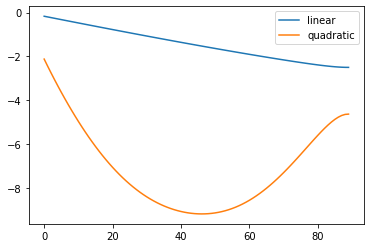

In [515]:
plt.plot(np.arange(90), V_linear, label = 'linear')
plt.plot(np.arange(90), V_quadratic, label = 'quadratic')
plt.legend()